# Practical Data Science - Final Report
## Churn Dataset
In the following report, I will build a machine learning classifier to predict whether an individual customer will churn or not. This project is part of the Practical Data Science class at UPF Business School taught in 2022.

To implement a machine learning model, I use various concepts presented in class and found online. As the dataset is (almost) clean and ready to use, this script focuses on sampling, training, and model selection rather than data preprocessing. Although a good predicition ability is naturally desired when training ML models, the goal of this project is to construct an exemplary structure of a ML script. Therefore, no extensive effort has been spent on fine tuning the final model to achieve slightly improved predictions.
Where needed, additional markdown explanation will be given.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, mutual_info_score
from sklearn.pipeline import make_pipeline as sklearn_make_pipeline
from sklearn.svm import SVC
from imblearn.pipeline import make_pipeline as imblearn_make_pipeline
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE

In [2]:
d = pd.read_csv('data.csv')

In [3]:
d.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
d.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

**Data Visualization**

Before preprocessing the data and implementing the models I want to make a quick dive into data vizualization to better understand the data at hand. Therefore I analyzed the data with the goal to find out which input variables seem to be more important to the final question whether a customer churns or not. To make the report not to extensive I focus on presenting only interesting findings.

(For the data visualiation I used the following source: https://towardsdatascience.com/end-to-end-machine-learning-project-telco-customer-churn-90744a8df97d)

In [8]:
def percentage_stacked_plot(columns_to_plot, super_title):
    
    '''
    Prints a 100% stacked plot of the response variable for independent variable of the list columns_to_plot.
            Parameters:
                    columns_to_plot (list of string): Names of the variables to plot
                    super_title (string): Super title of the visualization
            Returns:
                    None
    '''
    
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    #fig = plt.figure(figsize=(12, 5 * number_of_rows)) 
    fig = plt.figure(figsize=(14, 7 * number_of_rows)) 
    fig.suptitle(super_title, fontsize=22,  y=.95)
 

    # loop to each column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # calculate the percentage of observations of the response variable for each group of the independent variable
        # 100% stacked bar plot
        prop_by_independent = pd.crosstab(d[column], d['Churn']).apply(lambda x: x/x.sum()*100, axis=1)

        prop_by_independent.plot(kind='bar', ax=ax, stacked=True,
                                 rot=0, color=['springgreen','salmon'])

        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5),
                  title='Churn', fancybox=True)

        # set title and labels
        ax.set_title('Proportion of observations by ' + column,
                     fontsize=16, loc='left')

        ax.tick_params(rotation='auto')

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

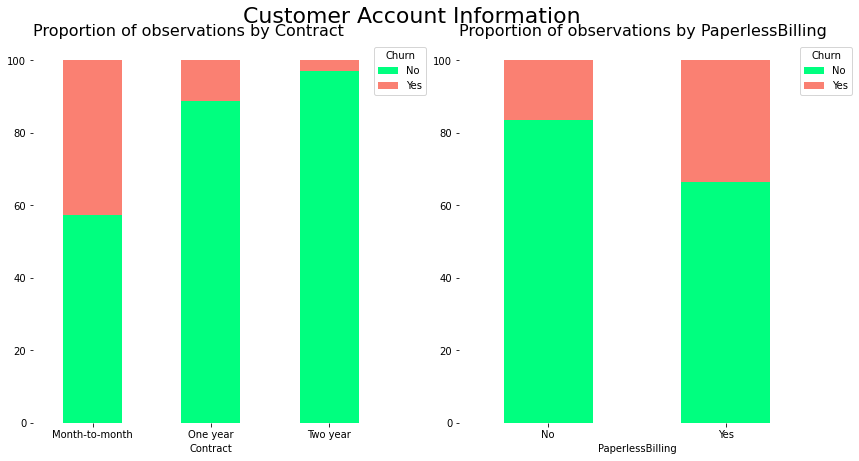

In [9]:
account_columns = ['Contract', 'PaperlessBilling']
percentage_stacked_plot(account_columns, 'Customer Account Information')

**Customer Account Information**: The analysis of the customer account information yields some interesting findinds. The above plots show that customers that are on a month-to-month contract are much more likely to churn compared to the customers that are on a 1 year or 2 year contract. Moreover, customers that have paperless billing are much more likely to churn than other customers. 

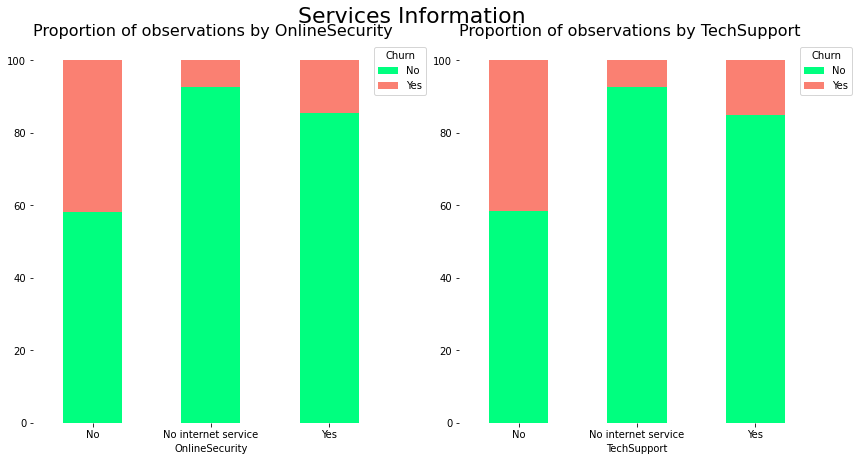

In [10]:
services_columns = ['OnlineSecurity', 'TechSupport',]
percentage_stacked_plot(services_columns, 'Services Information')

**Services Information:** The plot on the left side shows that customers which do not have the online securtiy service are much more likely to churn compared to those, who have this service. Another interesting finding is that the TechSupport also has a relationship with the likelihood of a customer churning or not. Customers who did not book this service are more likely compared to the customers who have the TechSupport Service. 

Next we use the `mutual_info_score` metric of the sklearn package to get a better understanding of the relevance input factors of the dataset  

In [11]:
# function that computes the mutual infomation score between a categorical serie and the column Churn
def compute_mutual_information(categorical_serie):
    return mutual_info_score(categorical_serie, d.Churn)

# select categorial variables excluding the response variable 
categorical_variables = d.select_dtypes(include=object).drop('Churn', axis=1)

# compute the mutual information score between each categorical variable and the target
feature_importance = categorical_variables.apply(compute_mutual_information).sort_values(ascending=False)
feature_importance = feature_importance.drop("customerID")
feature_importance = feature_importance.sort_values()

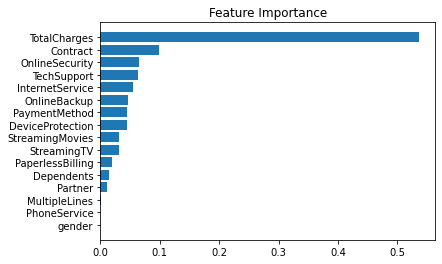

In [12]:
plt.barh(feature_importance.index, feature_importance, align='center')
plt.title("Feature Importance")
plt.show()

**Feature Importance:** This analysis confirms my previous findings that the type of contract the customer has highly influences his likelihood of churning. Moreover, it can be confirmed that the security service as well as the TechSupport also play an important role in determining whether or not a customer is going to churn. 

On the other hand it is observable that for example the gender, the type of phone service the customer booked and number of lines do not seem to be very relevant. 

##### Investigating the balance in the target column
I want to find out whether the target column `Churn` is balanced or not and what values it takes.

In [13]:
d['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

`Churn` turns out to be a binary column. The records are unbalanced (more "No" than "Yes"). An unbalanced dataset used for training can bias the model and deteriorate prediction results. I will combat this problem later on.

##### Unknown Values
I check for NAs to see which columns and rows are complete.

In [14]:
d.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Luckily, the dataset is clean and does not require dealing with NA values.

Let us take a look at the datatypes of the available columns.

In [15]:
d.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Almost all columns are objects, which is likely attributed to them being filled with different character strings. However, `MonthlyCharges` is numerical whereas `TotalCharges` is not. I will investigate column `TotalCharges` in more detail.

In [16]:
# total charges should be numerical just like monthly charges
d['TotalCharges'].head(10)

0      29.85
1     1889.5
2     108.15
3    1840.75
4     151.65
5      820.5
6     1949.4
7      301.9
8    3046.05
9    3487.95
Name: TotalCharges, dtype: object

`TotalCharges` seems to have only numerical values in the first 10 lines. Nevertheless, it was assigned as datatype `object` instead of a numerical datatype.

There seem to be some entries in the `TotalCharges` column that are not filled with a number but an empty value " ". Let us take a closer look at these rows.

In [17]:
d[d['TotalCharges']==' '][['customerID', 'tenure', 'TotalCharges']]

,customerID,tenure,TotalCharges
488,4472-LVYGI,0,
753,3115-CZMZD,0,
936,5709-LVOEQ,0,
1082,4367-NUYAO,0,
1340,1371-DWPAZ,0,
3331,7644-OMVMY,0,
3826,3213-VVOLG,0,
4380,2520-SGTTA,0,
5218,2923-ARZLG,0,
6670,4075-WKNIU,0,


Some values in `TotalCharges` are empty (" "). The reason for this is that the tenure (i.e. the duration of the current contract) is 0 months. The customer has not been charged yet, so I assign 0 to the `TotalCharges` column.

In [18]:
d['TotalCharges'] = np.where(d['TotalCharges'] == ' ', 0, d['TotalCharges'])
d['TotalCharges'] = d['TotalCharges'].astype('float64')

For development reasons, I copy the initial dataframe d to an imputation. This has purely been done for convenience during the development process as it allowed me to safeguard our progress.

In [29]:
imp1 = d.copy()
imp1.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Many columns are still object datatype. I want to convert them in more useful datatypes such as `category`.

To attain that, I first create lists for the columns I want to have as numerical datatype and another list for the categorical datatype. I will use these lists later on for applying transformation in the pipeline.

I use list comprehension to exclude the target column `Churn` as I do not want to apply any transformations to it later on.

Additionally, I exclude the `customerID` column because it contains an arbitrarly assigned ID number which should not have any predictive power over the target column.

In [30]:
num_cols = ['tenure', 'TotalCharges', 'MonthlyCharges']

In [31]:
cat_cols = [elem for elem in imp1.columns if (elem not in ['customerID', 'Churn']) & (elem not in num_cols)]
cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

Although I excluded `Churn` from the categorical columns list, I still want to convert it to the `category` datatype, so I add it to the loop below manually.

In [32]:
for col in cat_cols + ['Churn']:
    imp1[col] = pd.Categorical(imp1[col])

In [33]:
imp1.dtypes

customerID            object
gender              category
SeniorCitizen       category
Partner             category
Dependents          category
tenure                 int64
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float64
TotalCharges         float64
Churn               category
dtype: object

The column datatypes are now as desired. Therefore, I can now set our target column `Churn` as `y`, exclude the `customerID` column, and assign the remainder to `X`.

Subsequently, I use sklearn's `train_test_split` function to generate the training and test sets. For reproducebility reasons I set `random_state` to 0.

In [34]:
y = imp1['Churn']

In [35]:
X = imp1.drop(['customerID', 'Churn'], axis=1)

In [36]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

#### Implementing Pipelines for the Models
Having created the training and test sets, I can now create the pipeline for the ML model. A pipeline is necessary to prevent data leakage.

First, I combat the unbalanced distribution of values in the `Churn` target column.

An unbalanced dataset is a serious problem. In the dataset at hand, 74% of the observation have not churned. Therefore, if the model would predict _not churned_ for all, it immediately aquires 74% accuracy, although it did not use any of the data to recognize patterns.
In order to avoid this, it is necessary to rebalance the data. I focus on the following two ways to rebalance: oversampling and undersampling.

Undersampling is intuitive to understand. It deletes some data of the majority side so that the remaining dataset is balanced. However, it might create bias and decrease accuracy since it deletes parts of the data that could be used for training. Oversampling increases the data of the minority side. However, just copying minority data is problematic for several reasons. That is why SMOTE (Synthetic Minority Over-sampling Technique) is used here. SMOTE randomly generates data using the real data of the minority side, thus, producing more valuable training data.

As suggested in [the documentation](https://imbalanced-learn.org/stable/auto_examples/pipeline/plot_pipeline_classification.html) of package `imblearn`, a combination of over- and undersampling is advisable. In fact, the combination of SMOTE and ENN as implemented below has increased the performance of the models significantly.

In [37]:
enn = EditedNearestNeighbours()
smote = SMOTE(random_state=0)

#### Models Discussed in Class
In the following, I implement the classifier models that were discussed in class.

For tuning the hyperparameters, I use a stratified k-fold cross-validation and a gridspace.

In [38]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
gridspace = np.logspace(-100,1,10)

**Gridspace**: During the analysis I realized that whichever logspace I choose, the optimal parameter C for all models is always at the left border of the range. This indicates that the optimal solution for C would be 0. But in Python I cannot run the models with a C of 0. Because of that I choose a logspace which includes values very close to 0. 

**Why do I use recall over accuracy?** I chose recall as a measure of accuracy because of the specific business problem at hand: in the case at hand a false negative is much worse than a false positive, i.e. a customer that has been predicted as not churning that ends up churning is much worse than a customer that has been predicted as churning but ends up not churning.
The recall measure takes this into account as 

Recall = $\frac{true.positives}{true.positives + false.positives}$

Hence, maximizing recall is equivalent to minimizing false negatives.


#### Linear Support Vector Classifier
The first model I implement is a Linear Support Vector classifier. I define the transformer for the categorical and numerical columns first.

For categorical columns, I use the `OneHotEncoder` to encode the categorical columns into binary dummy columns.

For numerical columns, I standardize using the `StandardScaler`.

I use the `make_pipeline` function from `imblearn` because compared to the function from `sklearn`, it allows me to include ENN and SMOTE in the pipeline.

To reduce required computing power, few folds and iterations are used when tuning the hyperparameters.

In [39]:
categorical_transformer = imblearn_make_pipeline(
        OneHotEncoder(handle_unknown='ignore')
    )

transformer = ColumnTransformer(transformers=[
    ('numerical', StandardScaler(), num_cols),
    ('categorical', categorical_transformer, cat_cols)
])

svc = imblearn_make_pipeline(
    transformer,
    enn,
    smote,
    GridSearchCV(
        estimator=SVC(kernel='linear', max_iter = 500000),
        param_grid={
            'C': gridspace,
        },
        verbose=1,
        n_jobs=4,
        cv=kfold,
        scoring='recall'
    )
)

In [40]:
svc.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\fabia\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['tenure', 'TotalCharges',
                                                   'MonthlyCharges']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'O...
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
                              estimator=SVC(kernel='linear', max_iter=500000),
                              n_jobs=4,
                              param_grid={'C': array([1.00000000e-100, 1.66810054e-089, 2.78255940e-078, 4.64158883e-067,
       7.74263683e-056, 1.29154967e-044, 2.15443469e-033, 3.59381366e-022,
       5.99484250e-011, 1.00000000e+001])},
                              scoring='recall', verbose=1))])

In [41]:
svc[-1].best_estimator_

SVC(C=1e-100, kernel='linear', max_iter=500000)

In [42]:
pred = svc.predict(x_test)

I evaluate the model based on Recall. Out of curiosity I also compute Accuracy here.

In [43]:
print(f"Accuracy on test set: {accuracy_score(y_test, pred)*100:.2f}%")

Accuracy on test set: 66.00%


In [44]:
print(f"Recall on test set: {recall_score(y_test, pred, pos_label='Yes')*100:.2f}%")

Recall on test set: 89.30%


#### RBF Support Vector Machine
Next, I implement the RBF (radial basis function) Support Vector Machine. I use the same transformers, sampling methods, gridspace, folds, and scoring function.

Again, I limited the hyperparameter tuning to a minimum as to not create computationally expensive code.

In [45]:
svm_rbf = imblearn_make_pipeline(
    transformer,
    enn,
    smote,
    GridSearchCV(
        estimator=SVC(kernel='rbf', max_iter = 500000),
        param_grid={
            'C': gridspace,
            'gamma': ['auto', 'scale']
        },
        verbose=1,
        n_jobs=4,
        cv=kfold,
        scoring='recall'
    )
)

In [46]:
svm_rbf.fit(x_train, y_train);

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\fabia\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


In [47]:
svm_rbf[-1].best_estimator_

SVC(C=1e-100, gamma='auto', max_iter=500000)

In [48]:
pred = svm_rbf.predict(x_test)

In [49]:
print(f"Accuracy on test set: {accuracy_score(y_test, pred)*100:.2f}%")

Accuracy on test set: 63.52%


In [50]:
print(f"Recall on test set: {recall_score(y_test, pred, pos_label='Yes')*100:.2f}%")

Recall on test set: 91.18%


#### Polynomial Support Vector Machine
The next model is the Polynomial Support Vector Machine. Again, I keep all steps equal and limit computational costs.

In [51]:
svm_poly = imblearn_make_pipeline(
    transformer,
    enn,
    smote,
    GridSearchCV(
        estimator=SVC(kernel='poly', max_iter = 500000),
        param_grid={
            'C': gridspace,
            'gamma': ['auto', 'scale'],
            'degree': [2, 3]
        },
        verbose=1,
        n_jobs=4,
        cv=kfold,
        scoring='recall'
    )
)

In [52]:
svm_poly.fit(x_train, y_train);

Fitting 3 folds for each of 40 candidates, totalling 120 fits


c:\Users\fabia\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
  warnings.warn(


In [53]:
svm_poly[-1].best_estimator_

SVC(C=1e-100, degree=2, gamma='auto', kernel='poly', max_iter=500000)

In [54]:
pred = svm_poly.predict(x_test)

In [55]:
print(f"Accuracy on test set: {accuracy_score(y_test, pred)*100:.2f}%")

Accuracy on test set: 67.42%


In [56]:
print(f"Recall on test set: {recall_score(y_test, pred, pos_label='Yes')*100:.2f}%")

Recall on test set: 86.63%


#### Sigmoid Support Vector Machine
The last model I implement is a Sigmoid Support Vector Machine.

In [57]:
svm_sig = imblearn_make_pipeline(
    transformer,
    enn,
    smote,
    GridSearchCV(
        estimator=SVC(kernel='sigmoid', max_iter = 500000),
        param_grid={
            'C': gridspace,
            'gamma': ['auto', 'scale']
        },
        verbose=1,
        n_jobs=4,
        cv=kfold,
        scoring='recall'
    )
)

In [58]:
svm_sig.fit(x_train, y_train);

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\fabia\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


In [59]:
svm_sig[-1].best_estimator_

SVC(C=1e-100, gamma='auto', kernel='sigmoid', max_iter=500000)

In [60]:
pred = svm_sig.predict(x_test)

In [61]:
print(f"Accuracy on test set: {accuracy_score(y_test, pred)*100:.2f}%")

Accuracy on test set: 65.86%


In [62]:
print(f"Recall on test set: {recall_score(y_test, pred, pos_label='Yes')*100:.2f}%")

Recall on test set: 89.57%


### Final Model
I retrain the winning model on the entire dataset so that all input data is used for training.

The best model for our dataset is `svm_rbf` which attains the highest Recall score among the four models. 

In [63]:
winner_model = svm_rbf.fit(X, y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\fabia\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


In [64]:
winner_model[-1].best_estimator_

SVC(C=1e-100, gamma='auto', max_iter=500000)

The model is now ready to be used in production.